In [25]:
import os
import pydicom
import numpy as np
import datetime
import traceback
import matplotlib.pyplot as plt

In [26]:
file_path = 'dicom_files/Image0043.dcm'

In [27]:
df = pydicom.dcmread(file_path)

In [28]:
df

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 174
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113704.1.111.4384.1418036076.18246
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.46.670589.54.2.18.1
(0002, 0013) Implementation Version Name         SH: '18.1.0.0'
-------------------------------------------------
(0004, 1430) Directory Record Type               CS: 'IMAGE'
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20141208'
(0008, 0013) Instance Creation Time              TM: '162436'
(0008, 0016) SOP Class UID                       UI:

In [29]:
# Extracting relevant information from dicom file

# Getting patient weight
try:
    weight_grams = float(df.PatientWeight)*1000
except:
    traceback.print_exc()
    weight_grams = 75000
    estimated = True

try:
    # Get Scan time
    scantime = datetime.datetime.strptime(df.AcquisitionTime,'%H%M%S.%f')
    # Start Time for the Radio pharmaceutical Injection
    injection_time = datetime.datetime.strptime(df.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime,'%H%M%S.%f')
    # Half Life for Radionuclide # seconds
    half_life = float(df.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife)
    # Total dose injected for Radionuclide
    injected_dose = float(df.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)

    # Calculate decay
    decay = np.exp(-np.log(2) * (scantime - injection_time).seconds / half_life);
    # Calculate the dose decayed during procedure
    injected_dose_decay = injected_dose*decay # in Bq
except:
    traceback.print_exc()
    decay = np.exp(-np.log(2)*(1.75*3600)/6588) # 90 min waiting time, 15 min preparation
    injected_dose_decay = 420000000 * decay # 420 MBq
    estimated = True

Traceback (most recent call last):
  File "C:\Users\atharv_savarkar\AppData\Local\Temp\ipykernel_6496\1372944146.py", line 13, in <module>
    scantime = datetime.datetime.strptime(df.AcquisitionTime,'%H%M%S.%f')
  File "c:\users\atharv_savarkar\appdata\local\programs\python\python39\lib\_strptime.py", line 568, in _strptime_datetime
    tt, fraction, gmtoff_fraction = _strptime(data_string, format)
  File "c:\users\atharv_savarkar\appdata\local\programs\python\python39\lib\_strptime.py", line 349, in _strptime
    raise ValueError("time data %r does not match format %r" %
ValueError: time data '162412' does not match format '%H%M%S.%f'


In [30]:
# Calculate SUV # g/ml
raw = df.pixel_array
suv = raw*weight_grams/injected_dose_decay

In [31]:
# Max SUV
np.max(suv)

0.48951147137498996

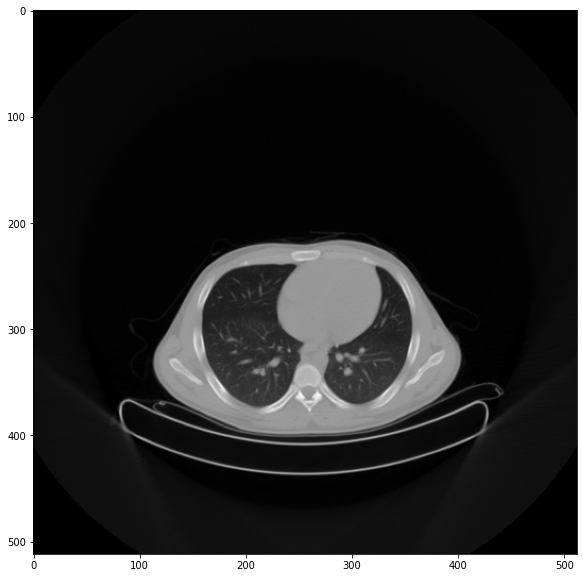

In [32]:
plt.figure(figsize=(10, 10))
plt.imshow(suv, cmap='gray')